# ASTR 598 Astrostatistics
## HW2 Part 2
## Hayden Smotherman, Chris Suberlack, Winnie Wang
## To run this Notebook:

Data files have not been uploaded to github because of size. Group 2 is analyzing NSC data, which should all be in group2/HW_2/. The NSC files are generated by uploading the HW2_DL_NCS.ipynb notebook to datalab servers, running the notebook, then downloading the two .csv files that are output.

In [1]:
# Imports 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.table import vstack
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import numpy as np
from astropy.io import fits
import pandas as pd

In [2]:
# Load the NSC data ... takes 2 mins 
# Group two is only using NSC data
table_neg = Table.read('NSC_stripe82_Dec_negative.csv')
table_pos = Table.read('NSC_stripe82_Dec_positive.csv')

# Stack the two tables vertically 
# ( rows over rows,  since the columns ARE IDENTICAL )
# this is even faster than any other merge, etc. 
nsc = vstack([table_neg, table_pos])

## Part (a)

In [4]:
#nsc

## Part (b)

## Part (c)

"Systematic errors in HLC, NSC (and joint) proper motions can be
also be gauged using ~10,000 quasars from the catalog DR12Q.fits from
http://www.sdss.org/dr12/algorithms/boss-dr12-quasar-catalog/"

"plot the median and sigmaG vs. RA for RA and Dec proper motion 
components for quasars with 17 < r < 20 from that file (~1 deg wide 
bins in RA, but try a factor of 3 smaller and larger bins and discuss). "


In [3]:
hdu = fits.open('DR12Q.fits')
#hdu.info()
db_qso = Table(hdu[1].data)

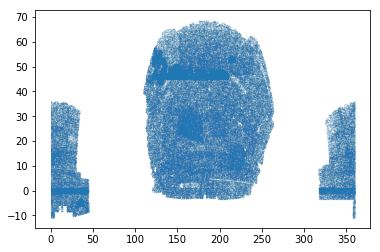

In [4]:
# quickly check coverage ...
%matplotlib inline
plt.scatter(db_qso['RA'], db_qso['DEC'], s=0.001)
# entire SDSS pretty much ! 

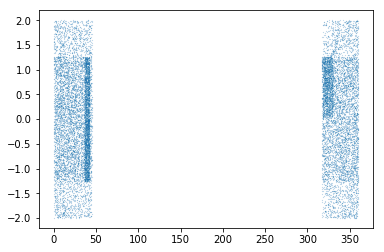

In [5]:
%matplotlib inline
# Select only the S82 part ...
m_ra = np.abs(db_qso['DEC']) < 2
m_dec = ( db_qso['RA'] < 50 ) | (300 < db_qso['RA'])
m = m_ra * m_dec 
plt.scatter(db_qso['RA'][m], db_qso['DEC'][m], s=0.01)

In [6]:
# re-express the ra from 0-360 to +/- 180 ..
db_qso['RA_W'] = np.where(db_qso['RA']>180, db_qso['RA']-360, db_qso['RA'])
nsc['ra_W'] = np.where(nsc['ra']>180, nsc['ra']-360, nsc['ra'])

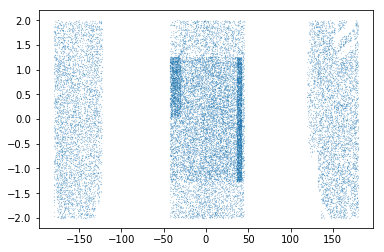

In [8]:
# Plot again...
m = np.abs(db_qso['DEC']) < 2
plt.scatter(db_qso['RA_W'][m], db_qso['DEC'][m], s=0.01)

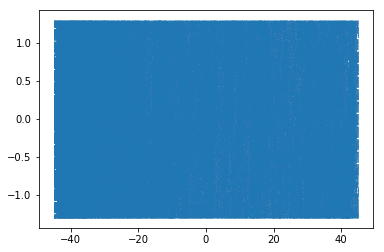

In [9]:
# that's just S82 because that's what we queried for ...
plt.scatter(nsc['ra_W'], nsc['dec'], s=0.0001)

907629

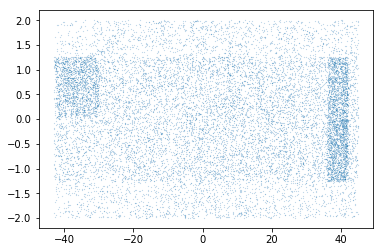

In [12]:
# Limit the DR12 QSO DB to ra limits ...

m_dec = np.abs(db_qso['DEC']) < 2
m_ra = np.abs(db_qso['RA_W']) < 50 
m = m_dec * m_ra
plt.scatter(db_qso['RA_W'][m], db_qso['DEC'][m], s=0.01)

In [ ]:
# All that has to do with 'MAG' : 
#cols = np.ravel(db_qso[m_qso].colnames)
#cols[np.array(['MAG' in x for x in  cols])]

In [93]:
# Grab SDSS magnitudes and errors for QSO, 
# probably more accurate than the NSC ones...
mag = Table(db_qso['PSFMAG'], names=('u', 'g', 'r', 'i','z'))
magerr = Table(db_qso['ERR_PSFMAG'], names=('u', 'g', 'r', 'i','z'))

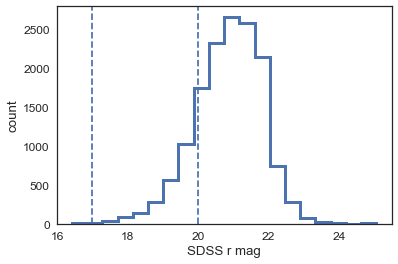

In [127]:
m_dec = np.abs(db_qso['DEC']) < 2
m_ra = np.abs(db_qso['RA_W']) < 50 
#for f in 'ugriz' : 
f = 'r'
m_mag = 15 < mag[f]
magmin, magmax = 17,20
plt.hist(mag[m_dec*m_ra*m_mag][f], histtype='step', bins=20, lw=3, label=f)
plt.axvline(magmin, ls='--')
plt.axvline(magmax, ls='--')
#plt.legend()
m_mag = (magmin< mag[f])*(mag[f]<magmax)
plt.xlabel('SDSS '+f+' mag')
plt.ylabel('count')

In [123]:
print('Of ', np.sum(m_ra*m_dec),' QSO within S82 footprint, ',
      np.sum(m_ra*m_dec*m_mag), ' are within' , magmin, '<',f,'<', magmax)

Of  14852  QSO within S82 footprint,  2517  are within 17 < r < 20


In [111]:
# cross-match the catalogs : only select the RA range 
# that makes sense from DB12 , and take only the objects 
# that fulfil the magnitude cut ...

# this takes about 20 sec , so seems fine : 
# 
m_dec = np.abs(db_qso['DEC']) < 2
m_ra = np.abs(db_qso['RA_W']) < 50 
rmin, rmax = 17,20
m_r = (rmin < mag['r']) * (mag['r'] < rmax)
m_qso = m_dec * m_ra * m_r
print('Matching ', np.sum(m_qso), ' qso')

# I still limit the NSC catalog because 
# I want to get the cross matching time < 1 / H_0
# we don't expect dmag > 2 mag  between SDSS / NSC 
# if there were such discrepancy with a point source
# it's probably not too trustworthy...

m_mag = (rmin-2 < nsc['rmag'])*(nsc['rmag']<rmin+2)
m_dec = nsc['ra_W'] < 50
m_nsc = m_mag * m_dec
print('Against ', np.sum(m_nsc), ' NSC catalog sources...')

coords1 = SkyCoord(ra = db_qso['RA_W'][m_qso]*u.degree, 
                   dec=db_qso['DEC'][m_qso]*u.degree) 
coords2 = SkyCoord(ra = nsc['ra_W'][m_nsc]*u.degree, 
                   dec= nsc['dec'][m_nsc]*u.degree) 

# this is matching HLC to NSC, so that indices are into NSC catalog
# makes sense in this case since the NSC catalog is bigger than HLC here 
idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)  
print('Done crossmatching')


Matching  2517  qso
Against  4046261  NSC catalog sources
Done crossmatching


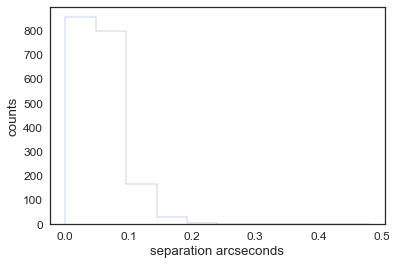

In [128]:
# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
qso = hstack([db_qso[m_qso], nsc[m_nsc][idx]], table_names = ['sdss', 'nsc'])
qso['sep_2d_arcsec'] = d2d.arcsec

%matplotlib inline
# plot the separation , select only good matches : 
x = qso['sep_2d_arcsec']
plt.hist( x[x<0.5],histtype='step')
plt.xlabel('separation arcseconds')
plt.ylabel('counts')

In [124]:
# Choose separation, and select only those object that have a nearest neighbor 
# from the NSC catalog within this radius ...
sep = 0.25
matched = qso['sep_2d_arcsec'] < sep
qsos =  qso[matched]
print('Of ', len(matched), ' QSO, we matched ', np.sum(matched), 'within ',sep,' arcsec')

Of  2517  QSO, we matched  1854 within  0.25  arcsec


"plot the median and sigmaG vs. RA for RA and Dec proper motion components for quasars with 17 < r < 20 from that file (~1 deg wide bins in RA, but try a factor of 3 smaller and larger bins and discuss)"

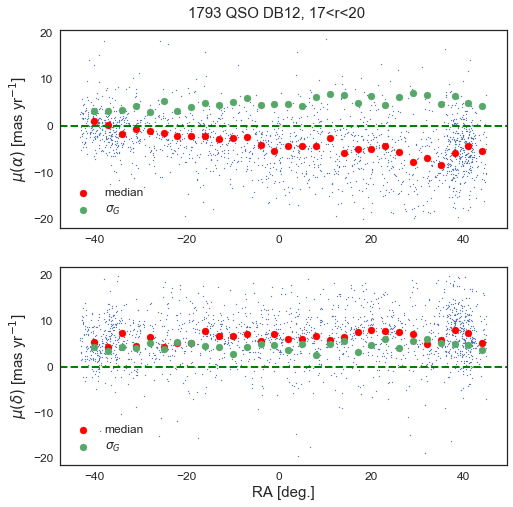

In [129]:
from scipy.stats import binned_statistic
from astroML import stats as astroMLstats
import seaborn as sns
sns.set(style='white', font_scale=1.2)

ra = qsos['ra_W']
dec = qsos['dec']
raPm = qsos['pmra']
decPm= qsos['pmdec']

bin_width = 3
bins = np.arange(min(ra), max(ra), bin_width)

fig,ax = plt.subplots(2,1,figsize=(8,8))

i = 0
for pm in [raPm, decPm] : 
    m = np.abs(pm) < 20 
    median = binned_statistic(ra[m], pm[m], statistic='median', bins=bins)
    sig = binned_statistic(ra[m], pm[m], statistic=astroMLstats.sigmaG, bins=bins)
    #im1 = ax[i].hexbin(ra[m], pm[m], bins='log', cmap=plt.cm.viridis,
    #           mincnt=1)
    ax[i].scatter(ra[m],pm[m], s=1, label='')
    ax[i].scatter(bins[1:], median.statistic, label='median', color='red')
    ax[i].scatter(bins[1:], sig.statistic, label=r'$\sigma_{G}$')
    ax[i].legend(fontsize=12, loc='lower left')
    ax[i].axhline(0,lw=2,ls='--', c='green')
    i += 1 

ax[0].set_ylabel(r'$\mu({\alpha})$'+' [mas yr'+''+r'$^{-1}$'+']', fontsize=15)
ax[1].set_ylabel(r'$\mu({\delta})$'+' [mas yr'+''+r'$^{-1}$'+']', fontsize=15)
ax[1].set_xlabel('RA [deg.]', fontsize=15)
fig.suptitle(str(len(ra[m]))+' QSO DB12, 17<SDSS r <20', y=0.92, fontsize=15)
plt.savefig('HW2_2c_QSO_SDSS_NSC_')

Quasars are very far away, so if all local motion is taken into account, there shouldn't be any tangential motion. There could be some radial motion (Hubble flow), but that's not what we are plotting above. 